<a target="_blank" href="https://colab.research.google.com/github/tcapraz/SOFA/blob/main/docs/notebooks/sc_multiome_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Before you start, make sure to set your runtime type to GPU in colab.

In [25]:
# Install SOFA + dependencies
!pip install --quiet biosofa

In [1]:
# download data 
!wget https://datasets.cellxgene.cziscience.com/484dbc33-c7dc-4e5e-9954-7f2a1cc849bc.h5ad # RNA-Seq
!mv 484dbc33-c7dc-4e5e-9954-7f2a1cc849bc.h5ad rna.h5ad
!wget https://datasets.cellxgene.cziscience.com/fecbd715-66f5-48ae-8c39-51a76d7f1d3d.h5ad # ATAC-Seq
!mv fecbd715-66f5-48ae-8c39-51a76d7f1d3d.h5ad atac.h5ad

--2024-11-06 09:37:23--  https://datasets.cellxgene.cziscience.com/484dbc33-c7dc-4e5e-9954-7f2a1cc849bc.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 18.172.112.45, 18.172.112.61, 18.172.112.87, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|18.172.112.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405964465 (387M) [binary/octet-stream]
Saving to: ‘484dbc33-c7dc-4e5e-9954-7f2a1cc849bc.h5ad’

-c7dc-4e5e-9954-7f2  24%[===>                ]  95.62M  22.3MB/s    eta 17s    ^C
--2024-11-06 09:37:30--  https://datasets.cellxgene.cziscience.com/fecbd715-66f5-48ae-8c39-51a76d7f1d3d.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 18.172.112.45, 18.172.112.61, 18.172.112.87, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|18.172.112.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sofa 
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from muon import MuData
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import scanpy as sc
import anndata as ad
from anndata import AnnData
import muon
from matplotlib import colors as mp_colors

# Analysis of a single-cell multiome data set

## Introduction

In this notebook we will explore how `SOFA` can be used to analyze multi-omics data from the DepMap [[1,2,3,4,5]](#1,#2,#3,#4,#5). 
Here we give a brief introduction what the SOFA model does and what it can be used for. For a more 
detailed description please refer to our preprint: https://doi.org/10.1101/2024.10.10.617527 


### The SOFA model
Given a set of real-valued data
matrices containing multi-omic measurements from overlapping samples (also called views),
along with sample-level guiding variables that capture additional properties such as batches
or mutational profiles, SOFA extracts an interpretable lower-dimensional data representation,
consisting of a shared factor matrix and modality-specific loading matrices. The goal of these 
factors is to explain the major axes of variation in the data. SOFA explicitly assigns a subset of factors 
to explain both the multi-omics data and the guiding
variables (guided factors), while preserving another subset of factors exclusively
for explaining the multi-omics data (unguided factors). Importantly, this feature allows the
analyst to discern variation that is driven by known sources from novel, unexplained sources
of variability.

#### Interpretation of the factors (Z)
Analogous to the interpretation of factors in PCA, SOFA factors ordinate samples along a
zero-centered axis, where samples with opposing signs exhibit contrasting phenotypes along
the inferred axis of variation, and the absolute value of the factor indicates the strength of the
phenotype. Importantly, SOFA partitions the factors of the low-rank decomposition into
guided and unguided factors: the guided factors are linked to specific guiding variables,
while the unguided factors capture global, yet unexplained, sources of variability in the data. 
The factor values can be used in downstream analysis tasks related to the samples, such as clustering 
or survival analysis. The factor values are called Z in SOFA.

#### Interpretation of the loading weights (W)
SOFA’s loading weights indicate the importance of each feature for its respective factor,
thereby enabling the interpretation of SOFA factors. Loading weights close to zero indicate
that a feature has little to no importance for the respective factor, while large magnitudes
suggest strong relevance. The sign of the loading weight aligns with its corresponding factor,
meaning that positive loading weights indicate higher feature levels in samples with positive
factor values, and negative loading weights indicate higher feature levels in samples with
negative factor values. The top loading weights can be simply inspected or used in downstream analysis such as gene set 
enrichment analysis. The factor values are called W in SOFA.

#### Supported data
SOFA expects a set of matrices containing omics measurements with matching and aligned samples and different features. 
Currently SOFA only supports Gaussian likelihoods, for the multi-omics data. 
Data should therefore be appropriately normalized according to
its omics modality. Additionally, data should be centered and scaled.


For the guiding variables SOFA supports Gaussian, Bernoulli and Categorical likelihoods. Guiding variables
can therefore be continuous, binary or categorical. Guiding variables should be vectors with matching samples with 
the multi-omics data.

In SOFA the multi-omics data is denoted as X and the guiding variables as Y.


### Single-cell multiome data set of the human cortex
The data we analyze in this notebook was generated by [[1]](#1). The authors simultaneously profiled the transcriptome (RNA) and chromatin accessibility (ATAC) of 45549 single cells of the human cerebral cortex at 6 different developmental stages. The authors identified 13 different cell types in the data. 
We will fit a SOFA model with 15 factors and guide the first 13 factors with a different cell type label. The 13 guided factors will explain the molecular differences between the cell types, while the 2 unguided factors are free to explain within cell type variation.
We will first load the data and do some basic preprocessing,  then fit a SOFA model and perform various downstream analyses. 



<a id="1">[1]</a> 
Zhu, K. et al. Multi-omic profiling of the developing human cerebral cortex at the single-cell level. Sci Adv 9, eadg3754 (2023).

## Load and preprocess

In [4]:
adata_rna= sc.read_h5ad("rna.h5ad") 

In [5]:
adata_rna

AnnData object with n_obs × n_vars = 45549 × 30113
    obs: 'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_joint_wnn_umap', 'X_umap'

In [6]:
# basic preprocessing
adata_rna.X = adata_rna.raw.X
# normalization to total library size
sc.pp.normalize_total(adata_rna)
# log transformation
sc.pp.log1p(adata_rna)


In [7]:
adata_atac= sc.read_h5ad("atac.h5ad")

In [8]:
# select highly variable genes
sc.pp.highly_variable_genes(
    adata_rna,
    n_top_genes=2000,
    flavor="seurat",
    subset=True
)
sc.pp.highly_variable_genes(
    adata_atac,
    n_top_genes=2000,
    flavor="seurat",
    subset=True
)

In [9]:
# scale the data
sc.pp.scale(adata_rna)
sc.pp.scale(adata_atac)

### Set up Xmdata for SOFA


#### Manually

SOFA requires the following slots in uns:
* llh: "gaussian" 
Currently only the Gaussian likelihood for the multi-omics data is supported.

and in obsm:
* mask: boolean vector of length number of samples that masks samples with missing values

In [10]:
metadata = adata_rna.obs
adata_rna.uns["llh"] = "gaussian"
adata_rna.X = adata_rna.X
adata_rna.obsm["mask"] = ~np.any(np.isnan(adata_rna.X), axis=1)

In [11]:
adata_atac.uns["llh"] = "gaussian"
adata_atac.X = adata_atac.X
adata_atac.obsm["mask"] = ~np.any(np.isnan(adata_atac.X), axis=1)

adata_rna.var_names = adata_rna.var["feature_name"]
adata_atac.var_names = adata_atac.var["feature_name"]

#### Using SOFA's sofa.tl.get_ad()
Alternatively we can use SOFA's inbuilt sofa.tl.get_ad() function to create the appropriate `AnnData` object

In [12]:
# First we convert the `AnnData` objects to dataframes
rna_df = adata_rna.to_df()
atac_df = adata_atac.to_df()

In [13]:
# Then use sofa.tl.get_ad() with default parameters
adata_atac = sofa.tl.get_ad(rna_df)
adata_rna = sofa.tl.get_ad(atac_df)

In [14]:
# wrap the individual `AnnData` objects in a `MuData`
Xmdata = MuData({"RNA":adata_rna, "ATAC":adata_atac})
Xmdata

MuData object with n_obs × n_vars = 45549 × 4000
  2 modalities
    RNA:	45549 x 2000
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    ATAC:	45549 x 2000
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'

### Set up Ymdata for SOFA

As described in the introduction, we would like to guide the first 13 factors with the 13 cell type labels.
To this end we first need to one hot encode the cell type labels. We make use of the OneHotEncoder of `scikit-learn`:

In [15]:
onc = OneHotEncoder()
onc_data = np.array(onc.fit_transform(metadata[["cell_type"]]).todense())
# convert to df for later
celltype_df = pd.DataFrame(onc_data, columns= onc.categories_[0])
celltype_df

astrocyte  caudal ganglionic eminence derived interneuron  \
0            0.0                                             0.0   
1            0.0                                             0.0   
2            0.0                                             0.0   
3            0.0                                             0.0   
4            0.0                                             0.0   
...          ...                                             ...   
45544        0.0                                             0.0   
45545        0.0                                             0.0   
45546        0.0                                             0.0   
45547        0.0                                             0.0   
45548        0.0                                             0.0   

       endothelial cell  glutamatergic neuron  inhibitory interneuron  \
0                   0.0                   1.0                     0.0   
1                   0.0                   1.0                     0.0   
2                   0.0                   1.0                     0.0   
3                   0.0                   1.0                     0.0   
4                   0.0                   1.0                     0.0   
...                 ...                   ...                     ...   
45544               0.0                   0.0                     0.0   
45545               0.0                   0.0                     0.0   
45546               0.0                   0.0                     0.0   
45547               0.0                   0.0                     0.0   
45548               0.0                   0.0                     0.0   

       medial ganglionic eminence derived interneuron  microglial cell  \
0                                                 0.0              0.0   
1                                                 0.0              0.0   
2                                                 0.0              0.0   
3                                                 0.0              0.0   
4                                                 0.0              0.0   
...                                               ...              ...   
45544                                             0.0              0.0   
45545                                             0.0              0.0   
45546                                             0.0              0.0   
45547                                             0.0              0.0   
45548                                             0.0              0.0   

       neural progenitor cell  oligodendrocyte  \
0                         0.0              0.0   
1                         0.0              0.0   
2                         0.0              0.0   
3                         0.0              0.0   
4                         0.0              0.0   
...                       ...              ...   
45544                     0.0              1.0   
45545                     0.0              0.0   
45546                     0.0              1.0   
45547                     0.0              1.0   
45548                     0.0              1.0   

       oligodendrocyte precursor cell  pericyte  radial glial cell  \
0                                 0.0       0.0                0.0   
1                                 0.0       0.0                0.0   
2                                 0.0       0.0                0.0   
3                                 0.0       0.0                0.0   
4                                 0.0       0.0                0.0   
...                               ...       ...                ...   
45544                             0.0       0.0                0.0   
45545                             1.0       0.0                0.0   
45546                             0.0       0.0                0.0   
45547                             0.0       0.0                0.0   
45548                             0.0       0.0      

each columns represents a different one hot (binary) encoded cell type

In [16]:
# convert each column to an `AnnData` object using sofa.tl.get_ad() and store in a list
# as each cell type is now represented as a binary vector we need to choose the "bernoulli" likelihood
celltype_ad = [sofa.tl.get_ad(pd.DataFrame(celltype_df.iloc[:,i], columns=[str(onc.categories_[0][i])]), llh = "bernoulli") for i in range(celltype_df.shape[1])]
# convert the list to a dictionary
cell_type_dict = {str(onc.categories_[0][i]):celltype_ad[i] for i in range(celltype_df.shape[1])} 

In [17]:
# wrap dictionary as `MuData`
Ymdata = MuData(cell_type_dict)
Ymdata

MuData object with n_obs × n_vars = 45549 × 13
  13 modalities
    astrocyte:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    caudal ganglionic eminence derived interneuron:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    endothelial cell:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    glutamatergic neuron:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    inhibitory interneuron:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    medial ganglionic eminence derived interneuron:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    microglial cell:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    neural progenitor cell:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    oligodendrocyte:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    oligodendrocyte precursor cell:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    pericyte:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    radial glial cell:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    vascular associated smooth muscle cell:	45549 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'

In [18]:
num_factors = 15
# In order to relate factors to guiding variables we need to provide a design matrix (guiding variables x number of factors) 
# indicating which factor is guided by which guiding variable.
# Here we just indicate that the first 6 factors are each guided by a different guiding variable:
design = np.zeros((len(Ymdata.mod), num_factors))
for i in range(len(Ymdata.mod)):
    design[i,i] = 1
# convert to torch tensor to make it usable by SOFA
design = torch.tensor(design)
design

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
       dtype=torch.float64)

## Fit the `SOFA` model

In [93]:
model = sofa.SOFA(Xmdata = Xmdata, # the input multi-omics data  
                  num_factors=num_factors, # number of factors to infer
                  Ymdata = Ymdata, # the input guiding variables
                  design = design, # design matrix relating factors to guiding variables
                  device='cuda', # set device to "cuda" to enable computation on the GPU, if you don't have a GPU available set it to "cpu"
                  subsample=2048, # for single-cell data it can be beneficial to subsample minibatches (here of size 2048) of the data for training, this speeds up the fitting process 
                  seed=42) # set seed to get the same results every time we run it

In [94]:
model.fit(n_steps=6000, lr=0.01, predict = True)

Current Elbo 2.50E+08 | Delta: -1523794: 100%|██████████| 6000/6000 [14:14<00:00,  7.02it/s] 


In [2]:
# if we would like to save the fitted model we can save it using:
#sofa.tl.save_model(model,"brain_example_model")

# to load the model use:
#model = sofa.tl.load_model("brain_example_model")

## Downstream analysis


### Convergence

We will first assess whether the ELBO loss of SOFA has converged by plotting it over training steps

Text(0, 0.5, 'ELBO')

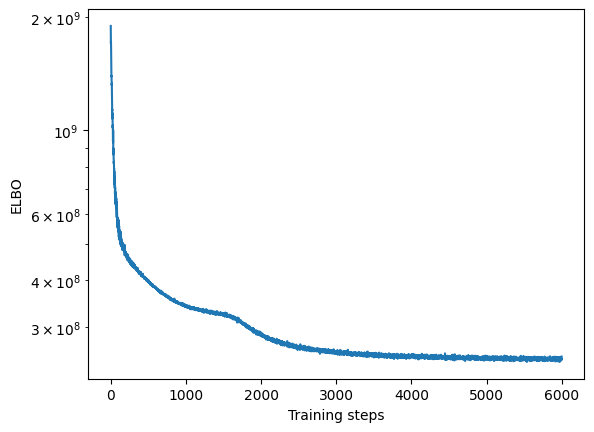

In [19]:
plt.semilogy(model.history)
plt.xlabel("Training steps")
plt.ylabel("ELBO")

### Variance explained

A good first step in a SOFA analysis is to plot how much variance is explained by each factor for each modality. This gives us an overview 
which factors are active across multiple modalities, capturing correlated variation across multiple measurements 
and which are private to a single modality, most probably capturing technical effects related to this modality.

<Axes: xlabel='View', ylabel='Factor'>

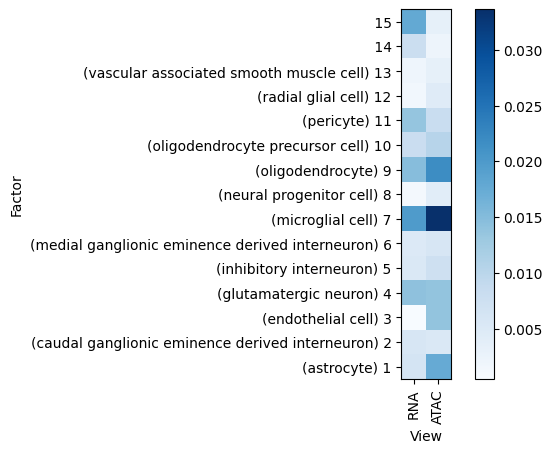

In [20]:
sofa.pl.plot_variance_explained(model)

<Axes: xlabel='View', ylabel='R2'>

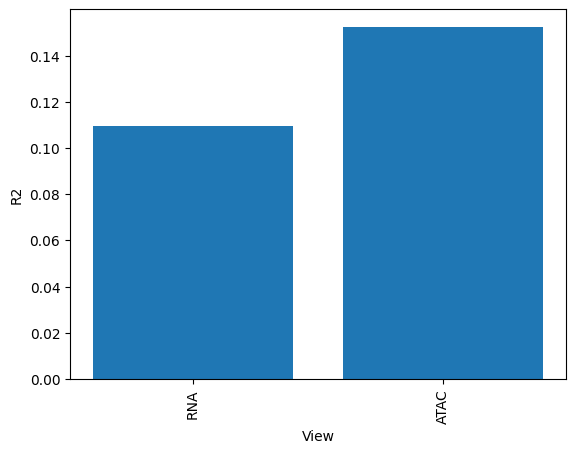

In [21]:
# We can also plot how much variance of each view is explained
sofa.pl.plot_variance_explained_view(model)

<Axes: xlabel='View', ylabel='R2'>

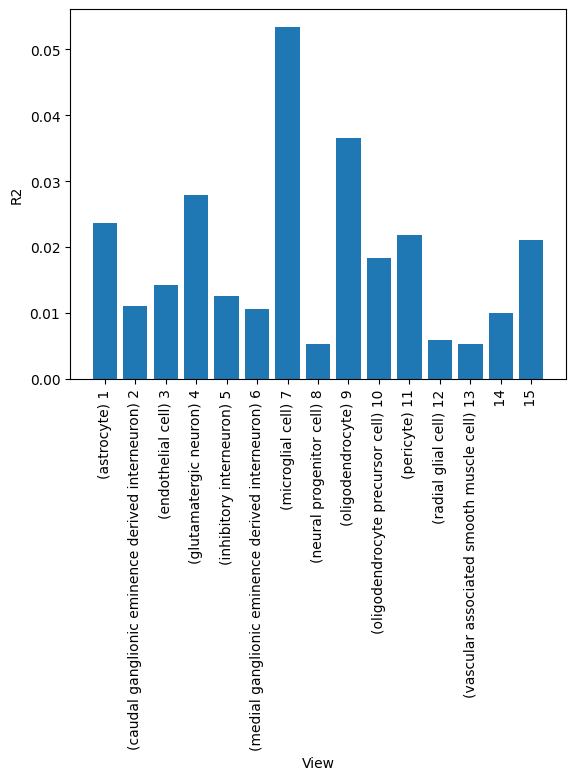

In [22]:
# or how much variance is explained by each factor in total
sofa.pl.plot_variance_explained_factor(model)

### Check factor guidance

<Axes: xlabel='Covariate', ylabel='Factor'>

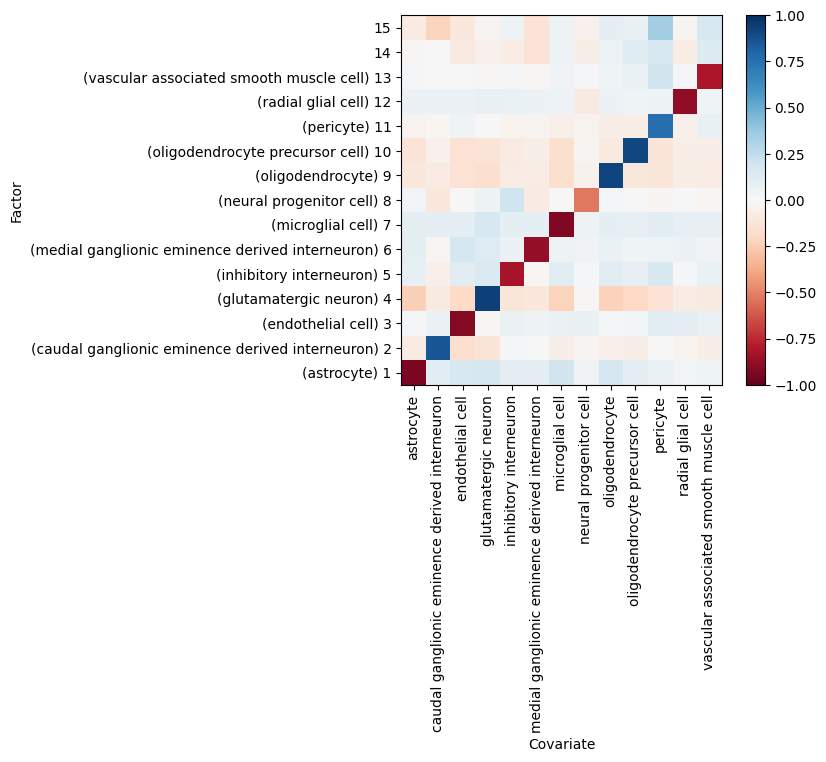

In [23]:
# plot correlation of factor values with cell type labels
sofa.pl.plot_factor_metadata_cor(model, celltype_df)

### Downstream analysis of the factor values

The factor values represent the new coordinates in lower dimensional space of our samples and have dimensions samples x factors. 
The factor values called Z in SOFA.
We can use the factor values for all kinds of downstream analyses on the sample level. Here we will cluster the unguided factors.

We first retrieve the factor values:

In [20]:
Z = sofa.tl.get_factors(model)
Z

Factor_1 (astrocyte)  \
4_AAACAGCCAACACTTG-1                   0.611896   
4_AAACAGCCACCAAAGG-1                   0.369894   
4_AAACAGCCATAAGTTC-1                   0.525656   
4_AAACATGCATAGTCAT-1                   0.484234   
4_AAACATGCATTGTCAG-1                   0.473560   
...                                         ...   
150666_TTTGTGAAGACAACAG-1              0.338253   
150666_TTTGTGAAGGCTGTGC-1              0.088728   
150666_TTTGTGAAGTAAGAAC-1              0.254422   
150666_TTTGTGAAGTCTTGAA-1              0.707852   
150666_TTTGTTGGTGATCAGC-1              0.890338   

                           Factor_2 (caudal ganglionic eminence derived interneuron)  \
4_AAACAGCCAACACTTG-1                                               -0.506728           
4_AAACAGCCACCAAAGG-1                                               -0.695359           
4_AAACAGCCATAAGTTC-1                                               -0.576934           
4_AAACATGCATAGTCAT-1                                               -0.433456           
4_AAACATGCATTGTCAG-1                                               -0.469949           
...                                                                      ...           
150666_TTTGTGAAGACAACAG-1                                           0.274610           
150666_TTTGTGAAGGCTGTGC-1                                           0.120536           
150666_TTTGTGAAGTAAGAAC-1                                          -0.270921           
150666_TTTGTGAAGTCTTGAA-1                                          -0.214515           
150666_TTTGTTGGTGATCAGC-1                                          -0.290386           

                           Factor_3 (endothelial cell)  \
4_AAACAGCCAACACTTG-1                          0.283791   
4_AAACAGCCACCAAAGG-1                          0.196381   
4_AAACAGCCATAAGTTC-1                          0.151626   
4_AAACATGCATAGTCAT-1                          0.094686   
4_AAACATGCATTGTCAG-1                          0.194220   
...                                                ...   
150666_TTTGTGAAGACAACAG-1                     0.021684   
150666_TTTGTGAAGGCTGTGC-1                     0.196474   
150666_TTTGTGAAGTAAGAAC-1                     0.105018   
150666_TTTGTGAAGTCTTGAA-1                     0.089128   
150666_TTTGTTGGTGATCAGC-1                     0.247877   

                           Factor_4 (glutamatergic neuron)  \
4_AAACAGCCAACACTTG-1                              1.593037   
4_AAACAGCCACCAAAGG-1                              1.779255   
4_AAACAGCCATAAGTTC-1                              2.239841   
4_AAACATGCATAGTCAT-1                              1.731916   
4_AAACATGCATTGTCAG-1                              2.000594   
...                                                    ...   
150666_TTTGTGAAGACAACAG-1                        -0.642276   
150666_TTTGTGAAGGCTGTGC-1                        -0.235622   
150666_TTTGTGAAGTAAGAAC-1                        -0.476804   
150666_TTTGTGAAGTCTTGAA-1                        -0.605852   
150666_TTTGTTGGTGATCAGC-1                        -0.622976   

                           Factor_5 (inhibitory interneuron)  \
4_AAACAGCCAACACTTG-1                                0.168398   
4_AAACAGCCACCAAAGG-1                                0.204215   
4_AAACAGCCATAAGTTC-1                                0.164921   
4_AAACATGCATAGTCAT-1                                0.098722   
4_AAACATGCATTGTCAG-1                                0.305656   
...                                                      ...   
150666_TTTGTGAAGACAACAG-1                           0.297069   
150666_TTTGTGAAGGCTGTGC-1                           0.401305   
150666_TTTGTGAAGTAAGAAC-1                           0.007705   
150666_TTTGTGAAGTCTTGAA-1                           0.340981   
150666_TTTGTTGGTGATCAGC-1                           0.332508   

                           Factor_6 (medial ganglionic eminence derived interneuron)  \
4_AAACAGCCAACACTTG-1                                      

In [26]:
# here we add the factors Z as obsm to the input object to be able to use scanpy for UMAP visualization
Xmdata.mod["RNA"].obsm["Z"] = Z.values
sc.pp.neighbors(Xmdata.mod["RNA"], use_rep="Z", key_added="Z_neighbors")
sc.tl.umap(Xmdata.mod["RNA"], neighbors_key="Z_neighbors", random_state=1)

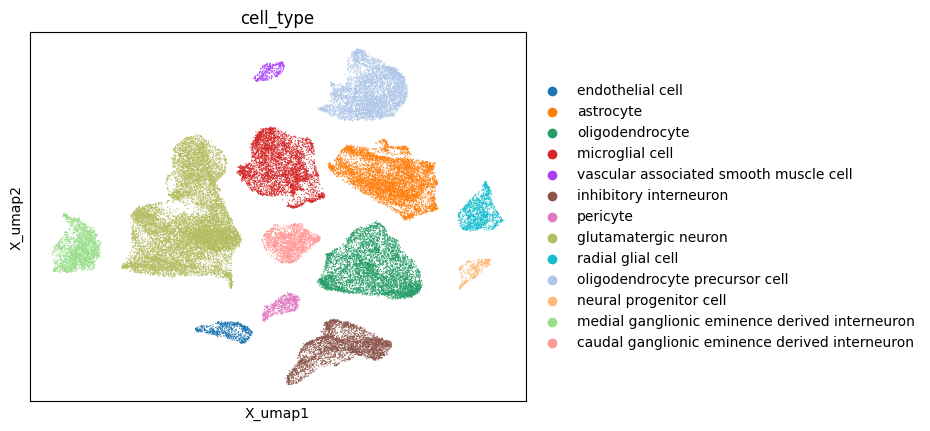

In [28]:
# plot the UMAP
Xmdata.mod["RNA"].obs = metadata
sc.pl.embedding(Xmdata.mod["RNA"], basis = "X_umap", color="cell_type")

As expected the cell type separate perfectly in the UMAP visualization. This is expected as we guided the first 13 factors with the cell type labels.
We can now overlay the unguided factors and check if we can identify interesting patterns:

In [23]:
# add each factor as obs to the input object
Xmdata.mod["RNA"].obs = pd.concat((Xmdata.mod["RNA"].obs, Z), axis=1)

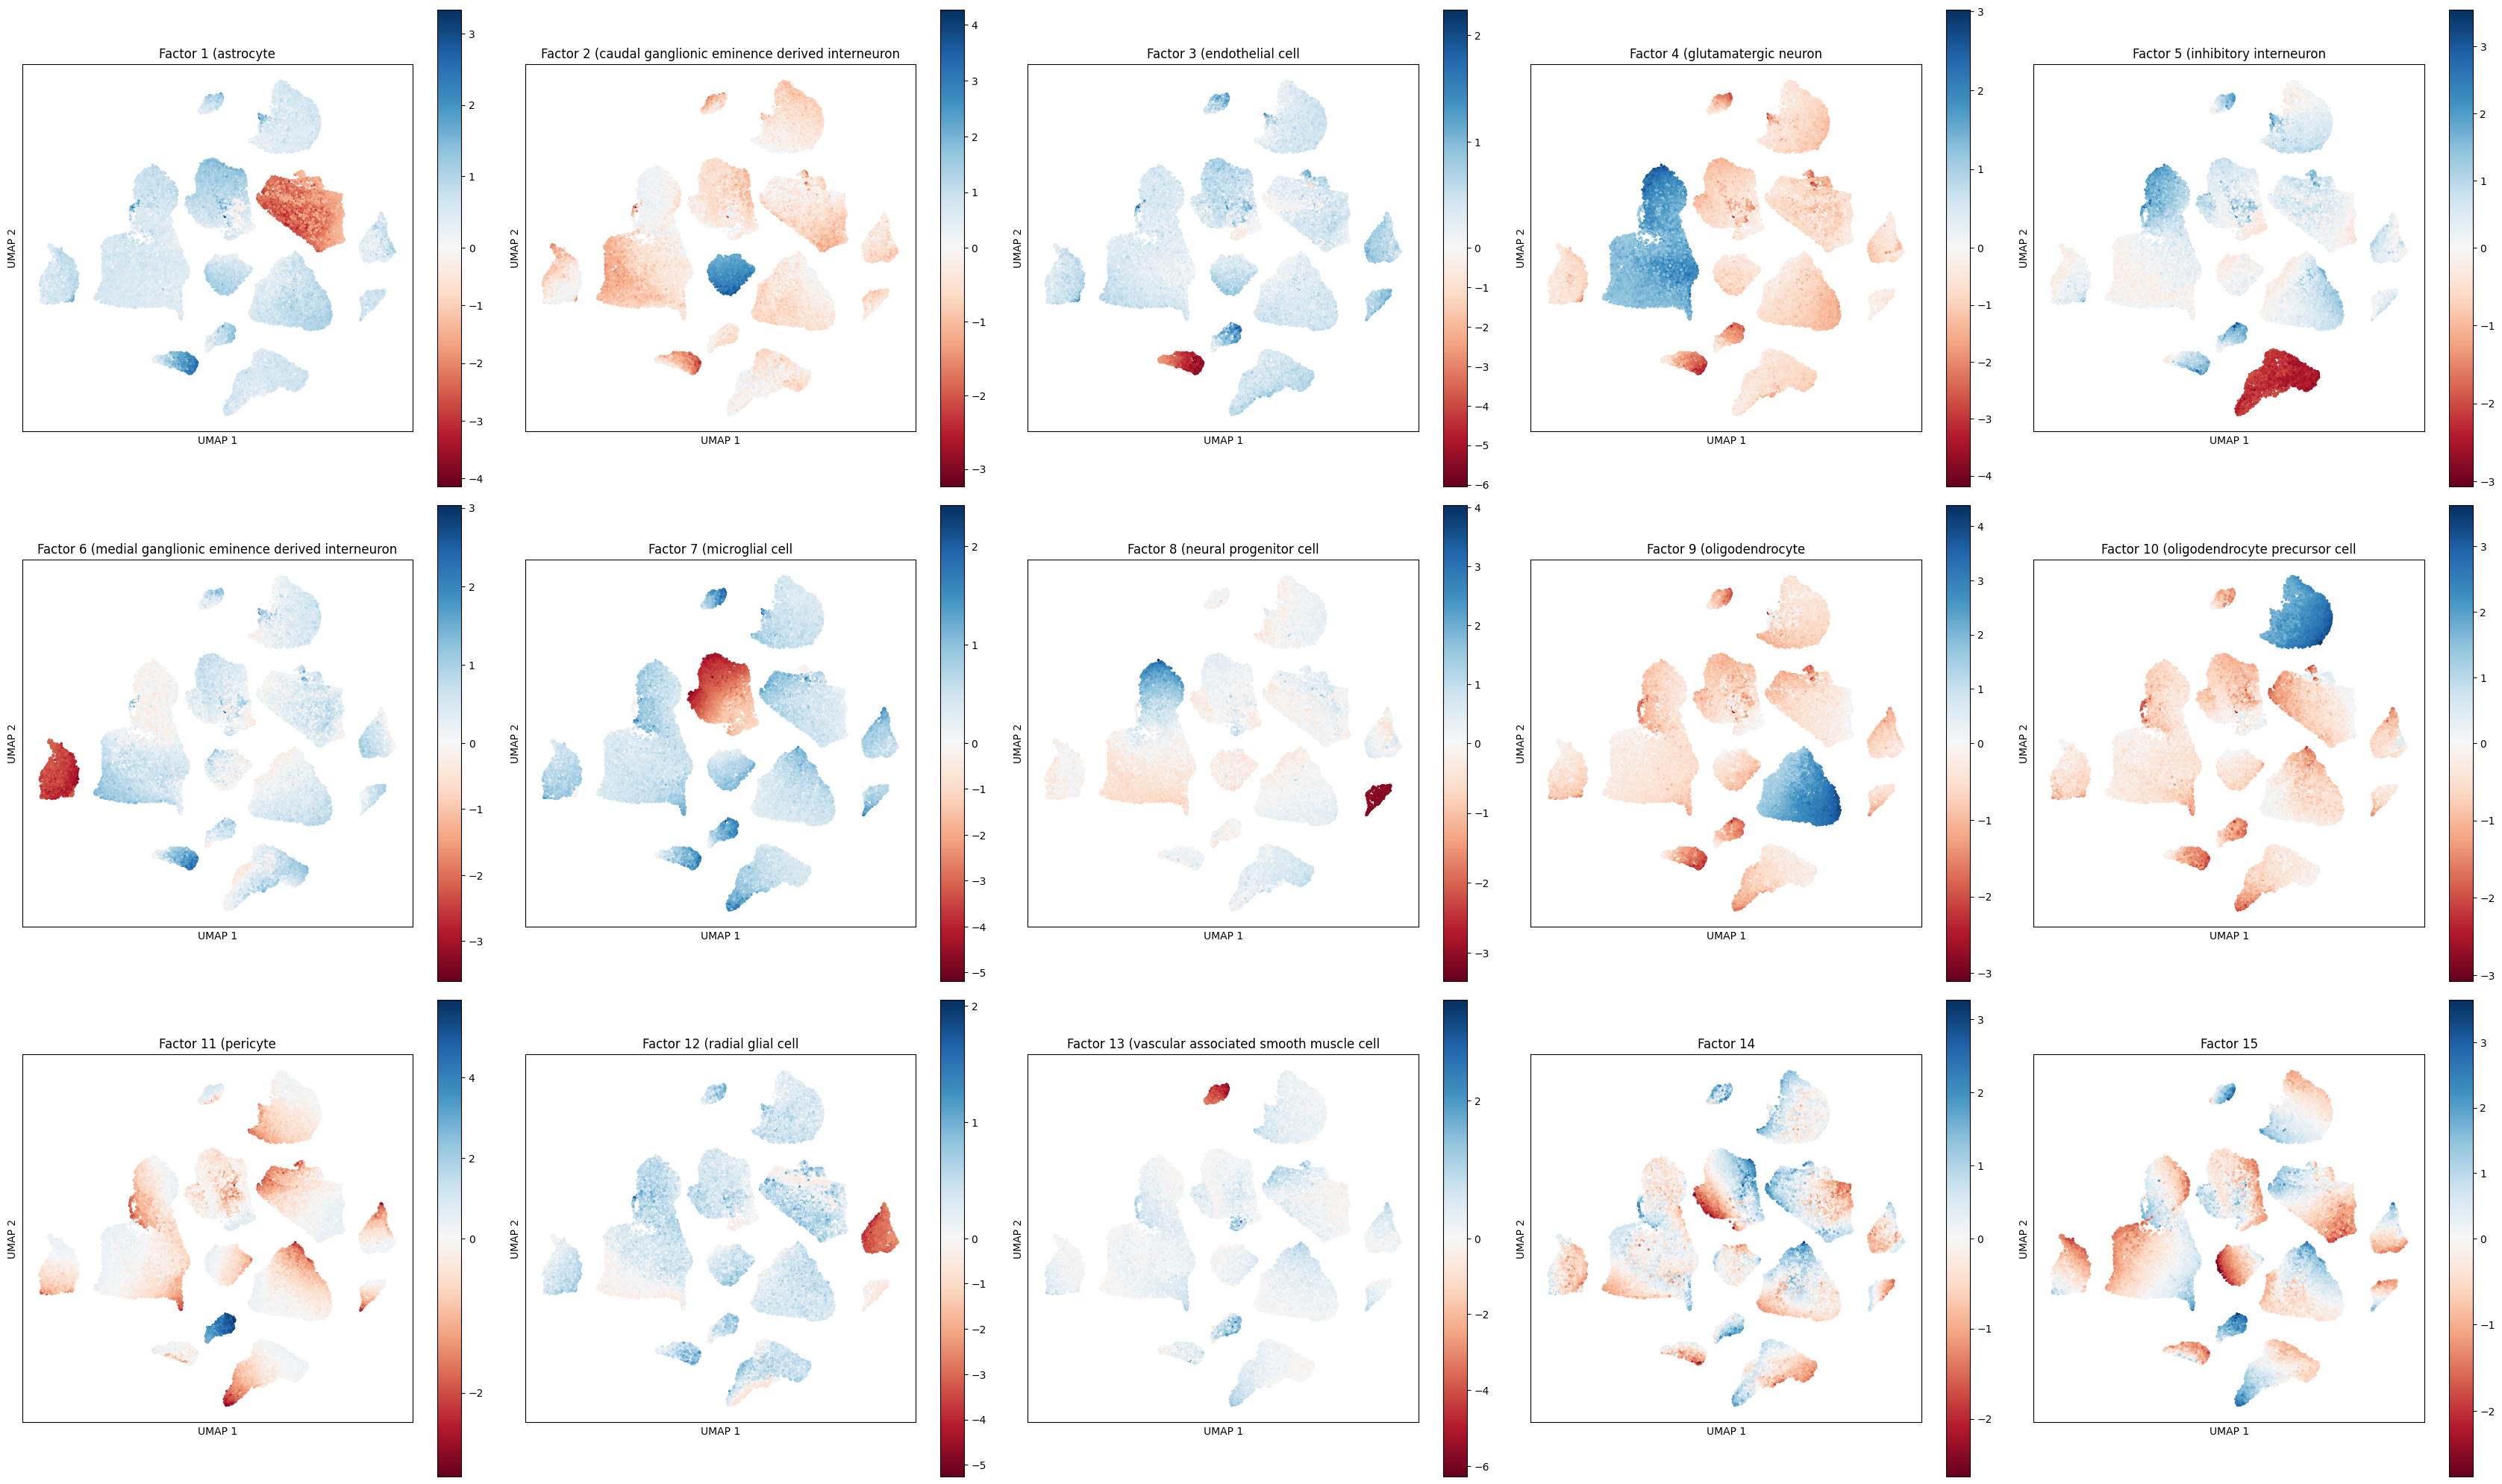

In [38]:
# plot a UMAP for each factor and color by factor value
fig,axes = plt.subplots(nrows =3, ncols=5,figsize=(34,20))

axes = axes.flatten()
for i,ax in enumerate(axes):
   
        divnorm=mp_colors.TwoSlopeNorm(vmin=np.min(Z.iloc[:,i]), vcenter=0, vmax=np.max(Z.iloc[:,i]))
        plot = ax.scatter(Xmdata.mod["RNA"].obsm["X_umap"][:,0], Xmdata.mod["RNA"].obsm["X_umap"][:,1], c=Z.iloc[:,i], s=120000 / Xmdata.mod["RNA"].shape[0], cmap="RdBu", norm=divnorm)
        ax.set_aspect("equal")
        if model.Ymdata is not None and i < len(model.Ymdata.mod):
            covariate = list(model.Ymdata.mod.keys())[i]
            ax.set_title("Factor " +str(i+1) + " ("+ str(covariate))
        else:
            ax.set_title("Factor " +str(i+1))
        plt.colorbar(plot) 
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")
        ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False, 
        left=False,# ticks along the top edge are off
        labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

plt.tight_layout()
matplotlib.rcdefaults() 

While the guided factors are active in their respective cell type clusters, the unguided factors (14 and 15) show gradients within in cell type clusters. Factor 14 shows a gradient mostly active in the microglial cell cluster.

### Downstream analysis of the loadings

We will now explore what molecular features Factor 14 and Factor 15 capture.

In [3]:
# specify the view of which we want to retrieve the loadings
# the loading matrix has dimensions factors x features
W_rna = sofa.tl.get_loadings(model, view="RNA")
W_rna

feature_name                                            SHOX    CSF2RA  \
Factor_1 (astrocyte)                               -0.018227  0.016628   
Factor_2 (caudal ganglionic eminence derived in...  0.061711  0.025978   
Factor_3 (endothelial cell)                         0.002676  0.046630   
Factor_4 (glutamatergic neuron)                     0.044140 -0.032026   
Factor_5 (inhibitory interneuron)                   0.021449  0.076019   
Factor_6 (medial ganglionic eminence derived in... -0.002214  0.011589   
Factor_7 (microglial cell)                          0.033687 -0.371200   
Factor_8 (neural progenitor cell)                  -0.040064  0.018456   
Factor_9 (oligodendrocyte)                         -0.045553 -0.086439   
Factor_10 (oligodendrocyte precursor cell)          0.013328 -0.076632   
Factor_11 (pericyte)                               -0.068400 -0.117113   
Factor_12 (radial glial cell)                       0.013457  0.035862   
Factor_13 (vascular associated smooth muscle cell) -0.020864 -0.006278   
Factor_14                                          -0.030205 -0.065338   
Factor_15                                           0.102394  0.111089   

feature_name                                           P2RY8      CD99  \
Factor_1 (astrocyte)                                0.008709 -0.085218   
Factor_2 (caudal ganglionic eminence derived in...  0.041309  0.008997   
Factor_3 (endothelial cell)                        -0.063564  0.013813   
Factor_4 (glutamatergic neuron)                    -0.020472 -0.004024   
Factor_5 (inhibitory interneuron)                   0.071614  0.111477   
Factor_6 (medial ganglionic eminence derived in...  0.009022  0.005203   
Factor_7 (microglial cell)                         -0.201232 -0.180759   
Factor_8 (neural progenitor cell)                  -0.022026  0.028713   
Factor_9 (oligodendrocyte)                         -0.095924 -0.091932   
Factor_10 (oligodendrocyte precursor cell)         -0.095766 -0.061523   
Factor_11 (pericyte)                               -0.107469 -0.063415   
Factor_12 (radial glial cell)                       0.016619 -0.008517   
Factor_13 (vascular associated smooth muscle cell)  0.057538  0.021366   
Factor_14                                          -0.098833 -0.098750   
Factor_15                                           0.161223  0.145873   

feature_name                                              XG      GYG2  \
Factor_1 (astrocyte)                               -0.032678 -0.051249   
Factor_2 (caudal ganglionic eminence derived in...  0.103602  0.066791   
Factor_3 (endothelial cell)                        -0.022183  0.019438   
Factor_4 (glutamatergic neuron)                     0.047451  0.072089   
Factor_5 (inhibitory interneuron)                   0.054973  0.011741   
Factor_6 (medial ganglionic eminence derived in... -0.001285  0.022863   
Factor_7 (microglial cell)                          0.048073  0.049734   
Factor_8 (neural progenitor cell)                   0.042819 -0.024957   
Factor_9 (oligodendrocyte)                         -0.071380 -0.057834   
Factor_10 (oligodendrocyte precursor cell)          0.004489 -0.009986   
Factor_11 (pericyte)                               -0.119831 -0.101984   
Factor_12 (radial glial cell)                      -0.005948 -0.048667   
Factor_13 (vascular associated smooth muscle cell)  0.016715 -0.011897   
Factor_14                                          -0.020684  0.015680   
Factor_15                                           0.143792  0.096924   

feature_name                                            ARSF     MXRA5  \
Factor_1 (astrocyte)                               -0.128016 -0.017553   
Factor_2 (caudal ganglionic eminence derived in...  0.096115  0.026817   
Factor_3 (endothelial cell)                         0.019055 -0.016783   
Factor_4 (glutamatergic neuron)                     0.020697  0.033083   
Factor_5 (inhibitory interneuron)                  -0.012790 -0.002646   
F

In [4]:
W_atac = sofa.tl.get_loadings(model, view="ATAC")
W_atac

feature_name                                            HES5    PRDM16  \
Factor_1 (astrocyte)                               -0.208182 -0.429047   
Factor_2 (caudal ganglionic eminence derived in... -0.036767 -0.069018   
Factor_3 (endothelial cell)                         0.026845  0.086176   
Factor_4 (glutamatergic neuron)                    -0.119810 -0.110515   
Factor_5 (inhibitory interneuron)                   0.074077  0.080980   
Factor_6 (medial ganglionic eminence derived in...  0.061534  0.110697   
Factor_7 (microglial cell)                          0.073273  0.076353   
Factor_8 (neural progenitor cell)                   0.094023 -0.073044   
Factor_9 (oligodendrocyte)                         -0.096187 -0.090426   
Factor_10 (oligodendrocyte precursor cell)          0.109106 -0.139850   
Factor_11 (pericyte)                               -0.096806 -0.082905   
Factor_12 (radial glial cell)                      -0.305815 -0.370938   
Factor_13 (vascular associated smooth muscle cell)  0.097635  0.021009   
Factor_14                                           0.064157 -0.044716   
Factor_15                                           0.004490 -0.062551   

feature_name                                        LINC01134    SLC2A5  \
Factor_1 (astrocyte)                                -0.000131  0.045786   
Factor_2 (caudal ganglionic eminence derived in...   0.001598 -0.011377   
Factor_3 (endothelial cell)                         -0.006730  0.032492   
Factor_4 (glutamatergic neuron)                     -0.008428 -0.065243   
Factor_5 (inhibitory interneuron)                   -0.000610  0.054926   
Factor_6 (medial ganglionic eminence derived in...  -0.012850  0.014597   
Factor_7 (microglial cell)                          -0.015753 -0.372691   
Factor_8 (neural progenitor cell)                   -0.020015 -0.010783   
Factor_9 (oligodendrocyte)                           0.002811 -0.057448   
Factor_10 (oligodendrocyte precursor cell)          -0.001256 -0.085660   
Factor_11 (pericyte)                                -0.013746 -0.031378   
Factor_12 (radial glial cell)                        0.014988  0.027542   
Factor_13 (vascular associated smooth muscle cell)  -0.025192  0.014730   
Factor_14                                           -0.024030  0.007258   
Factor_15                                            0.004475  0.026869   

feature_name                                          PIK3CD  TNFRSF1B  \
Factor_1 (astrocyte)                                0.080833  0.054359   
Factor_2 (caudal ganglionic eminence derived in... -0.025387 -0.038779   
Factor_3 (endothelial cell)                         0.092398 -0.062162   
Factor_4 (glutamatergic neuron)                    -0.076141 -0.082045   
Factor_5 (inhibitory interneuron)                   0.059176  0.070569   
Factor_6 (medial ganglionic eminence derived in... -0.108322  0.006335   
Factor_7 (microglial cell)                         -0.235887 -0.319122   
Factor_8 (neural progenitor cell)                   0.006819 -0.035352   
Factor_9 (oligodendrocyte)                         -0.100601 -0.064315   
Factor_10 (oligodendrocyte precursor cell)         -0.103560 -0.073114   
Factor_11 (pericyte)                                0.182597  0.024180   
Factor_12 (radial glial cell)                       0.026361  0.024751   
Factor_13 (vascular associated smooth muscle cell)  0.082244  0.057195   
Factor_14                                           0.054465 -0.057635   
Factor_15                                           0.085769  0.083807   

feature_name                                         AADACL4  SLC25A34-AS1  \
Factor_1 (astrocyte)                               -0.012543     -0.025898   
Factor_2 (caudal ganglionic eminence derived in...  0.004101      0.004330   
Factor_3 (endothelial cell)                         0.009899      0.019996   
Factor_4 (glutamatergic neuron)                     0.001842     -0.012405   
Factor_5 (inhibitory interneuron)      

To plot the top loadings use:

<Axes: xlabel='Loadings', ylabel='Features'>

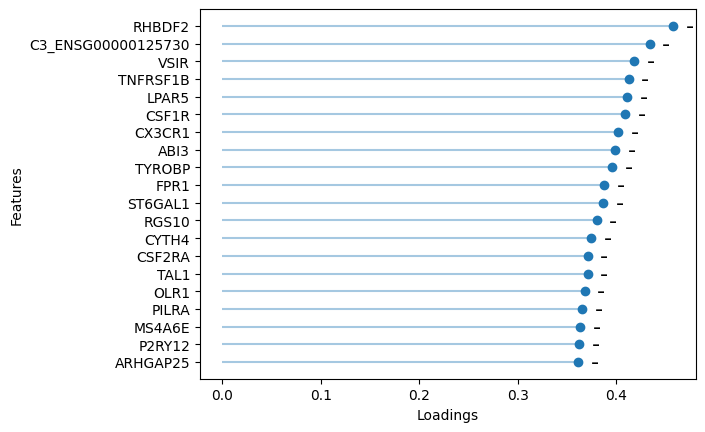

In [31]:
# plot the top negative RNA loadings of Factor 7 (microglial cells)
sofa.pl.plot_top_loadings(model, view="RNA", factor = 7, top_n=20, sign="-")

Among the top loadings of Factor 7 (guided by microglial cell label) are markers for microglial cells (CSF1R, CX3CR1, TYROBP).

#### Gene set overrepresentation analysis
We can use gene set overrepresentation analysis on the top loadings of a given factor. Factors typically represent axes of variation having a positive and a negative end. We will therefore both investigate the positive or negative loadings. 
This gives us an overview of which gene sets are enriched in this factor and what biological processes it probably captured. 

##### Factor 14

<Axes: xlabel='-log10 adjusted p-values', ylabel='Gene sets'>

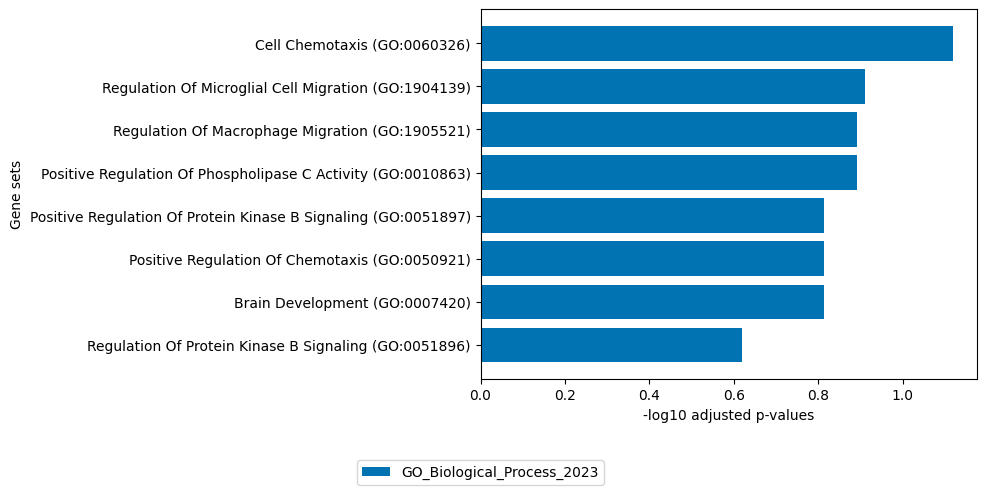

In [20]:
# get top 100 positive loadings of ATAC view
loadings = sofa.tl.get_top_loadings(model,factor=14, view="ATAC", sign="+", top_n=100)


sofa.pl.plot_enrichment(loadings, 
                        background=Xmdata.mod["ATAC"].var, # all genes considered in the analysis, used as background
                        db=[ "GO_Biological_Process_2023"],  # a list of databases for overrepresentation analysis,  
                        top_n=[8]) # the number of genesets for each database to plot
# sofa.pl.plot_enrichment uses the enrichr API, please refer to https://maayanlab.cloud/Enrichr/#libraries for a full list of available databases


<Axes: xlabel='-log10 adjusted p-values', ylabel='Gene sets'>

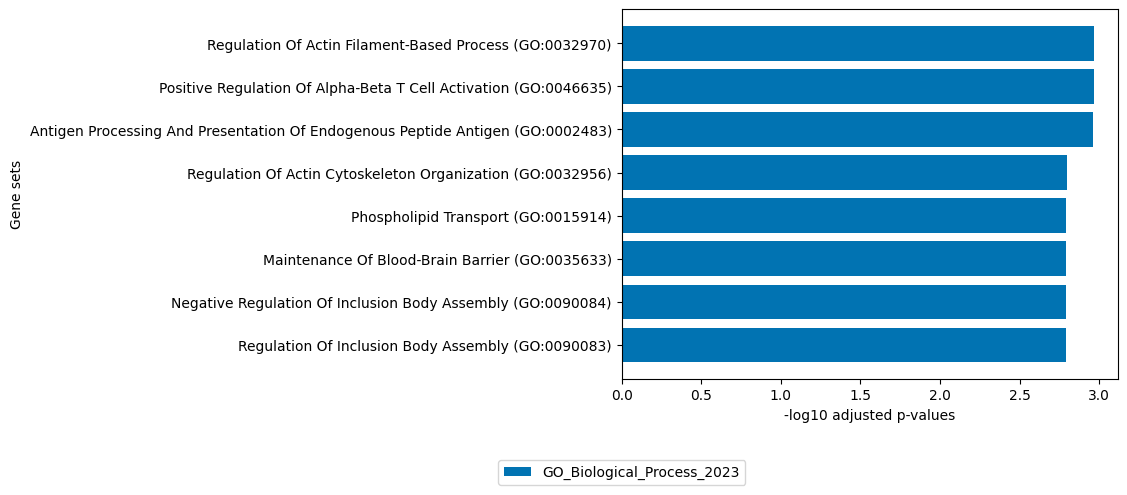

In [21]:
# get top 100 negative loadings of ATAC view
loadings = sofa.tl.get_top_loadings(model,factor=14, view="ATAC", sign="-", top_n=100)


sofa.pl.plot_enrichment(loadings, 
                        background=Xmdata.mod["ATAC"].var, # all genes considered in the analysis, used as background
                        db=["GO_Biological_Process_2023"],  # a list of databases for overrepresentation analysis,  
                        top_n=[8]) # the number of genesets for each database to plot
# sofa.pl.plot_enrichment uses the enrichr API, please refer to https://maayanlab.cloud/Enrichr/#libraries for a full list of available databases


##### Factor 15

<Axes: xlabel='-log10 adjusted p-values', ylabel='Gene sets'>

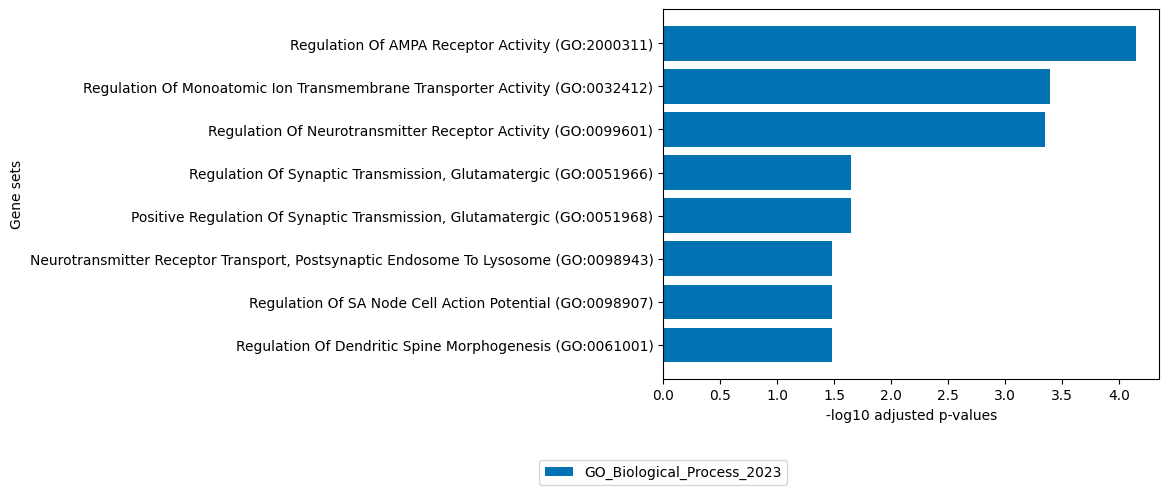

In [23]:
# get top 100 positive loadings of RNA view
loadings = sofa.tl.get_top_loadings(model,factor=15, view="RNA", sign="+", top_n=100)


sofa.pl.plot_enrichment(loadings, 
                        background=Xmdata.mod["RNA"].var, # all genes considered in the analysis, used as background
                        db=["GO_Biological_Process_2023"],  # a list of databases for overrepresentation analysis,  
                        top_n=[8]) # the number of genesets for each database to plot
# sofa.pl.plot_enrichment uses the enrichr API, please refer to https://maayanlab.cloud/Enrichr/#libraries for a full list of available databases

<Axes: xlabel='-log10 adjusted p-values', ylabel='Gene sets'>

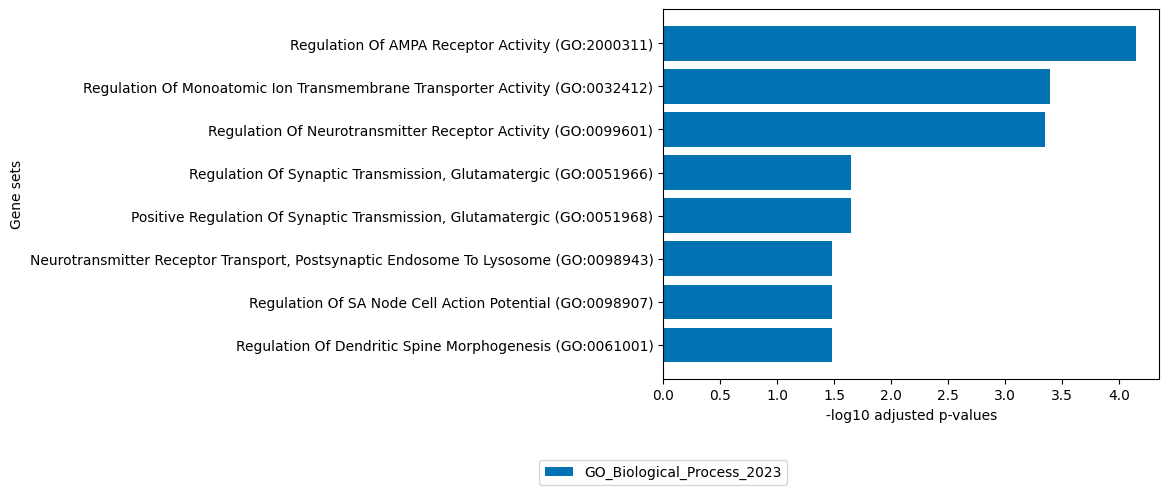

In [24]:
# get top 100 negative loadings of RNA view
loadings = sofa.tl.get_top_loadings(model,factor=15, view="RNA", sign="-", top_n=100)


sofa.pl.plot_enrichment(loadings, 
                        background=Xmdata.mod["RNA"].var, # all genes considered in the analysis, used as background
                        db=["GO_Biological_Process_2023"],  # a list of databases for overrepresentation analysis,  
                        top_n=[8]) # the number of genesets for each database to plot
# sofa.pl.plot_enrichment uses the enrichr API, please refer to https://maayanlab.cloud/Enrichr/#libraries for a full list of available databases